<a href="https://colab.research.google.com/github/MicheleGiambelli/Deep-Learning-Project/blob/Matteo/GoogleLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Dataset path
dataset_path = '/content/drive/MyDrive/food_12_small' #Mettete la vostra PATH al dataset

In [3]:
import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random

import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
from tqdm import tqdm


# Don't run the following code
Only preparation of dataset

In [ ]:
def validate_images(input_dir):
    # Get absolute path
    input_dir = os.path.abspath(input_dir)

    try:
        # Check if the directory exists
        os.listdir(input_dir)
    except FileNotFoundError:
        raise ValueError(f"{input_dir} is not an existing directory")

    # Save the path of files
    files = []
    for folder, subfolder, file in os.walk(input_dir):
        for f in file:
            files.append(os.path.join(folder, f))

    # Check the images requisite
    for idx, file_path in enumerate(files):
        # Check the extension
        if file_path.lower().endswith(('.jpg', '.jpeg')):
            try:
                # Open the image
                my_image = Image.open(file_path)

                # Check the image dimension (min 10kB, max 250 kB)
                if os.path.getsize(file_path) > 10240 and os.path.getsize(file_path) <= 250000:

                    # Check if the image is in RGB mode
                    if my_image.mode == "RGB":

                        #Convert my_image in numpy array
                        image_data = np.array(my_image)

                        # Check if the image has the height and width min request (100 pixel)
                        h, w, c = image_data.shape
                        if h >= 224 and w >= 224:

                            # Check if the variance of pixels is greater than 10 to avoid monotone images
                            if np.var(image_data) > 10:
                                continue  # Valid image, check the next one
                            else:
                                print(f"Image {file_path} is invalid: Variance is less than 10.")
                        else:
                            print(f"Image {file_path} is invalid: Dimensions are too small ({h}x{w}).")
                    else:
                        print(f"Image {file_path} is invalid: Not in RGB mode.")
                else:
                    print(f"Image {file_path} is invalid: File size is not correct.")

            except Exception as e:
                print(f"Image {file_path} could not be processed: {e}")

            # Delete the image is not valid
            try:
                os.remove(file_path)
                print(f"Deleted invalid image: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")

        else:
            print(f"File {file_path} is not an image.")


validate_images("food_13/images")

ValueError: /content/food_13/images is not an existing directory

Now we are going to reduce the number of images in each folder. The 13th folders have 1000 images each one of them. We are going to reduce them of the 80%.

In [ ]:
def reduce_images(input_dir, output_dir, num_images):
    # List all the files in the selected folder
    all_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

    # Random selection of the files that will be mantained
    files_to_mantain = random.sample(all_files, num_images)

    # Check that the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # CCopy selected files in the output directory
    for file in files_to_mantain:
        shutil.copy(os.path.join(input_dir, file), os.path.join(output_dir, file))

    print(f"Folder '{input_dir}' reduced to {num_images} images.")



input_dir = "food_12/images"
output_dir = "food_12_small"
# Percentage of images to mantain
num_images = 200
# Set the seed
random.seed(42)

# Apply the function to all the folders
for folder in os.listdir(input_dir):
    folder_dir = os.path.join(input_dir, folder)
    output_folder_dir = os.path.join(output_dir, folder)
    if os.path.isdir(folder_dir):
        reduce_images(folder_dir, output_folder_dir, num_images)

Folder 'food_13/images\beef_tartare' reduced to 200 images.
Folder 'food_13/images\bruschetta' reduced to 200 images.
Folder 'food_13/images\caesar_salad' reduced to 200 images.
Folder 'food_13/images\cannoli' reduced to 200 images.
Folder 'food_13/images\chicken_wings' reduced to 200 images.
Folder 'food_13/images\chocolate_cake' reduced to 200 images.
Folder 'food_13/images\club_sandwich' reduced to 200 images.
Folder 'food_13/images\dumplings' reduced to 200 images.
Folder 'food_13/images\hot_dog' reduced to 200 images.
Folder 'food_13/images\ice_cream' reduced to 200 images.
Folder 'food_13/images\pizza' reduced to 200 images.
Folder 'food_13/images\ramen' reduced to 200 images.


# Start from here


## EDA

In [ ]:
# Estrarre dimensioni delle immagini
image_sizes = []
for image_name in os.listdir(dataset_path):
    if image_name.endswith('.jpg'):
        with Image.open(os.path.join(dataset_path, image_name)) as img:
            image_sizes.append(img.size)  # (width, height)

# Analizzare larghezze e altezze
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

# Visualizzare la distribuzione
plt.hist(widths, bins=15, alpha=0.7, label='Widths')
plt.hist(heights, bins=15, alpha=0.7, label='Heights')
plt.title('Distribution of Images size')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.legend()
plt.show()


In [ ]:
# Calcolare il rapporto d'aspetto (larghezza/altezza)
aspect_ratios = [w / h for w, h in image_sizes]

# Visualizzare la distribuzione
plt.figure(figsize=(9, 4))
plt.hist(aspect_ratios, bins=30, color='blue')
plt.title('Distribuzione del Rapporto d\'Aspetto')
plt.xlabel('Rapporto Larghezza/Altezza')
plt.ylabel('Numero di immagini')
plt.show()

In [ ]:
# Estrarre dimensioni delle immagini
image_sizes = []
for image_name in os.listdir(dataset_path):
    if image_name.endswith('.jpg'):
        with Image.open(os.path.join(dataset_path, image_name)) as img:
            image_sizes.append(img.size)  # (width, height)

# Analizzare larghezze, altezze e rapporto d'aspetto
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]
aspect_ratios = [w / h for w, h in zip(widths, heights)]

# Distribuzione delle dimensioni (width, height)
width_counts, width_bins = np.histogram(widths, bins=30)
height_counts, height_bins = np.histogram(heights, bins=30)
width_percent = (width_counts / len(widths)) * 100
height_percent = (height_counts / len(heights)) * 100

# Distribuzione del rapporto d'aspetto
aspect_counts, aspect_bins = np.histogram(aspect_ratios, bins=30)
aspect_percent = (aspect_counts / len(aspect_ratios)) * 100

In [ ]:
# Creare i grafici
plt.figure(figsize=(13, 5))

# Primo grafico: Distribuzione delle dimensioni
plt.subplot(1, 2, 1)
plt.bar(width_bins[:-1], width_percent, width=width_bins[1] - width_bins[0], alpha=0.7, label='Width', align='edge')
plt.bar(height_bins[:-1], height_percent, width=height_bins[1] - height_bins[0], alpha=0.7, label='Height', align='edge')
plt.title('Distribution of size')
plt.xlabel('size')
plt.ylabel('%')
plt.legend()

# Secondo grafico: Distribuzione del rapporto d'aspetto
plt.subplot(1, 2, 2)
plt.bar(aspect_bins[:-1], aspect_percent, width=aspect_bins[1] - aspect_bins[0], alpha=0.7)
plt.title('Image aspect ratio')
plt.xlabel('img_aspect_ratio')
plt.ylabel('%')

# Mostrare i grafici
plt.tight_layout()
plt.show()

In [ ]:
# Caricare il file CSV
labels_df = pd.read_csv(labels_path, delimiter=';')

# Contare le immagini per ogni label
label_counts = labels_df['label'].value_counts()

# Creare il grafico a barre
plt.figure(figsize=(9, 4))
label_counts.plot(kind='bar')
plt.title('Distribuion images per labels')
plt.xlabel('Labels')
plt.ylabel('N. Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Caricare il file CSV
labels_df = pd.read_csv(csv_path, delimiter=";")

# Creare un dizionario con immagini per categoria
categories = labels_df['label'].unique()
category_to_images = {category: [] for category in categories}

for _, row in labels_df.iterrows():
    category_to_images[row['label']].append(row['name'])

# Impostare un seed per la riproducibilità
random.seed(123)
# Selezionare un'immagine casuale per ciascuna categoria
random_images = {category: random.choice(images) for category, images in category_to_images.items()}

# Impostare i plot
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for ax, (category, image_name) in zip(axes, random_images.items()):
    image_path = os.path.join(dataset_path, image_name)
    with Image.open(image_path) as img:
        ax.imshow(img)
        ax.set_title(category, fontsize=16, fontweight='bold')
        # ax.set_xlabel(f'Width: {img.width}px', fontsize=10)
        # ax.set_ylabel(f'Height: {img.height}px', fontsize=10)
        ax.axis('on')  # Mostra gli assi con i pixel

plt.tight_layout()
plt.show()

## Create the dataset

In [ ]:
# trans = transforms.Compose([
#         transforms.Resize((224, 224)),       # Resize a (height, width)
#         transforms.ToTensor(),                    # Converts to tensor
#         ])

# dataset = datasets.ImageFolder(root=dataset_path, transform=trans)
# image_tensors = []
# for img, _ in dataset:
#   image_tensors.append(img)

# stacked_images = torch.stack(image_tensors)
# mean = stacked_images.mean(dim=[0, 2, 3])
# std = stacked_images.std(dim=[0, 2, 3])

In [ ]:
# print(mean)
# print(std)

tensor([0.5437, 0.4453, 0.3496])
tensor([0.2687, 0.2710, 0.2731])


Functions to load the dataset


In [15]:
def get_dataloader_workers():
    """Use as many processes working in parallel to read the data as # CPU cores.
    Other recommended range: 2 to 4"""
    import os
    return os.cpu_count()

def data_loader(dataset_path, batch_size, height=224, width=224, train_perc=0.7, val_perc=0.2, seed=123, mean=None, std=None):

    np.random.seed(seed)
    torch.manual_seed(seed)

    # Verifica che mean e std siano forniti
    if mean is None or std is None:
        raise ValueError("Mean and Std must be provided for normalization.")

    trans = transforms.Compose([
        transforms.Resize((height, width)),       # Resize a (height, width)

        # Data Augmentation
        # transforms.RandomResizedCrop(224),  # Crop casuale e resize a 224x224
        # transforms.RandomHorizontalFlip(),  # Flip orizzontale casuale

        transforms.ToTensor(),                    # Converts to tensor
        transforms.Normalize(mean=mean, std=std)  # Normalization
    ])

    # Upload dataset with ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=trans)

    # Compute splitting size
    dataset_size = len(dataset)
    train_size = int(train_perc * dataset_size)
    val_size = int(val_perc * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Creazione dei DataLoader
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=get_dataloader_workers())
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=get_dataloader_workers())
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=get_dataloader_workers())

    return dataset, train_loader, val_loader, test_loader

Load the dataset

In [16]:
mean = [0.5437, 0.4453, 0.3496]
std = [0.2687, 0.2710, 0.2731]

dataset, train_loader, val_loader, test_loader = data_loader(dataset_path = dataset_path,
                                                             batch_size = 64,
                                                             height = 224, width = 224,
                                                             mean = mean, std = std)

In [17]:
# Labels dictionary
class_to_idx = dataset.class_to_idx
class_to_idx

{'beef_tartare': 0,
 'bruschetta': 1,
 'caesar_salad': 2,
 'cannoli': 3,
 'chicken_wings': 4,
 'chocolate_cake': 5,
 'club_sandwich': 6,
 'dumplings': 7,
 'hot_dog': 8,
 'ice_cream': 9,
 'pizza': 10,
 'ramen': 11}

#### Visualization of the first batch in training set.

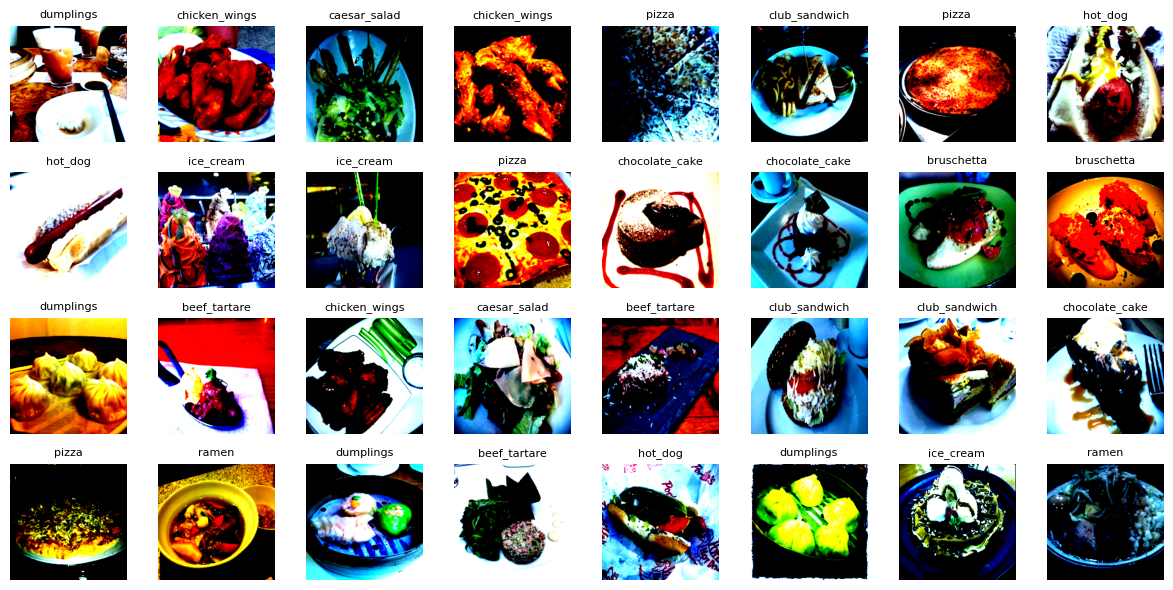

In [13]:
def id2label(labels, class_to_idx):
    """Return text labels from the corresponding numeric labels in the Fashion-MNIST dataset."""
    text_labels = list(class_to_idx.keys())
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """
    Plot a list of images.

    Args:
        imgs: List or tensor of images to display.
        num_rows: Number of rows in the plot grid.
        num_cols: Number of columns in the plot grid.
        titles: Titles for each image (optional).
        scale: Scaling factor for the figure size.
    """
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Convert tensor image to NumPy and permute for matplotlib compatibility
            ax.imshow(img.permute(1, 2, 0).numpy())
        else:
            # Assume PIL image
            ax.imshow(img)
        ax.axis('off')  # Hide axis
        if titles:
            ax.set_title(titles[i], fontsize=8)
    plt.tight_layout()
    plt.show()


# Ottieni un batch dal train_loader
X, y = next(iter(train_loader))

# Converto le etichette numeriche in testo (se hai il mapping class_to_idx)
text_labels = id2label(y, class_to_idx)

# Visualizzo le immagini
show_images(X, 4, 8, titles=text_labels)

In [14]:
# Mostro informazioni sul batch
print("\n")
print(f"First batch (of size {len(X)})\n")
print(f"Images in tensor format:\n {X}\n")
print(f"Labels (numeric):\n {y}\n")
print(f"Labels (text):\n {text_labels}\n")



First batch (of size 64)

Images in tensor format:
 tensor([[[[ 6.4737e-01,  6.6196e-01,  6.6196e-01,  ..., -1.7753e+00,
           -1.5272e+00, -1.2645e+00],
          [ 6.9115e-01,  7.0574e-01,  7.0574e-01,  ..., -1.8337e+00,
           -1.5126e+00, -1.2353e+00],
          [ 7.0574e-01,  7.2034e-01,  7.2034e-01,  ..., -1.8629e+00,
           -1.5710e+00, -1.2645e+00],
          ...,
          [ 1.9493e-01,  2.6791e-01,  2.5331e-01,  ...,  9.3926e-01,
            9.6845e-01,  9.9764e-01],
          [ 1.5115e-01,  6.3582e-02, -2.3986e-02,  ...,  8.9547e-01,
            9.6845e-01,  1.0122e+00],
          [ 4.8987e-02,  1.3655e-01,  9.2771e-02,  ...,  7.6412e-01,
            9.9764e-01,  1.0122e+00]],

         [[ 1.0773e+00,  1.0918e+00,  1.0918e+00,  ..., -1.2669e+00,
           -1.0065e+00, -7.6046e-01],
          [ 1.1207e+00,  1.1352e+00,  1.1352e+00,  ..., -1.3103e+00,
           -9.7752e-01, -6.8811e-01],
          [ 1.1207e+00,  1.1352e+00,  1.1352e+00,  ..., -1.3248e+00,
    

# GoogleLeNEt

## Inception block

In [18]:
class Inception(nn.Module):
    def __init__(self, input_channels, c1, c2, c3, c4, **kwargs):
        """
        Args:
            input_channels (int): Numero di canali in ingresso.
            c1 (int): Numero di canali di output per il percorso 1 (conv 1x1).
            c2 (tuple): (c2_reduce, c2_out), riduzione con 1x1 -> convoluzione 3x3.
            c3 (tuple): (c3_reduce, c3_out), riduzione con 1x1 -> convoluzione 5x5.
            c4 (int): Numero di canali di output per il percorso 4 (pooling + conv 1x1).
        """
        super(Inception, self).__init__(**kwargs) #super --> costruttore di nn.Module fondamentale in Pytorch per inizializzare la classe correttamente

        # Path 1: Single 1x1 Convolution
        self.path1 = nn.Conv2d(input_channels, c1, kernel_size=1)

        # Path 2: 1x1 -> 3x3 Convolution
        self.path2_1 = nn.Conv2d(input_channels, c2[0], kernel_size=1)
        self.path2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)

        # Path 3: 1x1 -> 5x5 Convolution
        self.path3_1 = nn.Conv2d(input_channels, c3[0], kernel_size=1)
        self.path3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)

        # Path 4: Max Pooling -> 1x1 Convolution
        self.path4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path4_2 = nn.Conv2d(input_channels, c4, kernel_size=1)

    def forward(self, x):

        p1 = F.relu(self.path1(x))
        p2 = F.relu(self.path2_2(self.path2_1(x)))
        p3 = F.relu(self.path3_2(self.path3_1(x)))
        p4 = F.relu(self.path4_2(self.path4_1(x)))
        output = torch.cat((p1, p2, p3, p4), dim=1)
        # Concatenate along the channel dimension
        return output

In [19]:
# Blocco 1
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.5)
)

# Blocco 2
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.5)
)

# Blocco 3
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.5)
)

# Blocco 4
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.5)
)

# Blocco 5
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
    nn.Flatten(),
    nn.Dropout(p=0.5)
)

# Rete completa
net = nn.Sequential(b1,b2,b3,b4,b5,
    nn.Linear(1024, 12),
    nn.Dropout(p=0.5),# Classificazione
)

In [21]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape' ,X.shape)

Sequential output shape torch.Size([1, 64, 56, 56])
Sequential output shape torch.Size([1, 192, 28, 28])
Sequential output shape torch.Size([1, 480, 14, 14])
Sequential output shape torch.Size([1, 832, 7, 7])
Sequential output shape torch.Size([1, 1024])
Linear output shape torch.Size([1, 12])
Dropout output shape torch.Size([1, 12])


# Training Loop

**nn.init.xavier_uniform_**: metodo di inizializzazione dei pesi ideato da Xavier Glorot e Yoshua Bengio.
- Distribuisce i pesi in modo uniforme su un intervallo basato sul numero di unità di input e di output del layer, per mantenere stabile la propagazione dei segnali avanti e indietro nella rete.
- Aiuta a prevenire problemi di vanishing/exploding gradients durante il training.

In [23]:


  device = torch.device(device if torch.cuda.is_available() else 'cpu')

  # Initialize the weights
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)

  network.apply(init_weights)

# Evaluate on test set

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("My_GoogleLeNet.pth", map_location=device))

net.eval()
Y_true = []
Y_pred = []
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    pred = net(X)
    Y_pred.extend(torch.argmax(pred, dim=1).cpu().numpy())
    Y_true.extend(y.cpu().numpy())

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

acc = accuracy_score(Y_true, Y_pred)
report = classification_report(Y_true, Y_pred, target_names=class_to_idx.keys())
conf_mat = confusion_matrix(Y_true, Y_pred, normalize='true')
conf_mat = np.round(conf_mat, 2)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=class_to_idx.keys())
print(f"Accuracy: {round(acc*100, 2)}%\n")
print(f"Report\n {report}")
disp.plot(cmap="Blues", xticks_rotation=90)

# ResNET

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1, dropout_prob=0.3):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        Y = self.dropout(Y)
        return F.relu(Y)

X = torch.rand(4, 3, 64, 64)
residual_block = Residual(3, 3, use_1x1conv=True)

output = residual_block(X)
print(output.shape)

torch.Size([4, 3, 64, 64])


In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=9, dropout_prob=0.3):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, dropout_prob=dropout_prob)
        self.layer2 = self.make_layer(64, 128, 2, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self.make_layer(128, 256, 2, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self.make_layer(256, 512, 2, stride=2, dropout_prob=dropout_prob)

        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1, dropout_prob=0.3):
        layers = []
        layers.append(Residual(in_channels, out_channels, strides=stride, use_1x1conv=True, dropout_prob=dropout_prob))
        for _ in range(1, num_blocks):
            layers.append(Residual(out_channels, out_channels, dropout_prob=dropout_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
def training_loop(network, training_loader, validation_loader,
                  epochs, learning_rate=0.01, patience=3,
                  device = "cuda",
                  save_model_name = "My_GoogleLeNet.pth"):

  device = torch.device(device if torch.cuda.is_available() else 'cpu')

  # Initialize the weights
  def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight, 1)
          nn.init.constant_(m.bias, 0)

  network.apply(initialize_weights)


  # Move the net to the GPU if is avaible
  print(f"Training on device {device}\n")
  network.to(device)
  # Create the optimization method
  optimizer = torch.optim.Adam(network.parameters(), lr = learning_rate)

  # Create the loss function
  loss_function = nn.CrossEntropyLoss()

  # Lists to store the training and evaluation losses/accuracy
  train_losses = []
  val_losses = []
  train_acc = []
  val_acc = []
  best_val_loss = float('inf')
  best_val_acc = 0.0
  best_epoch = 0

  # Start the training
  for epoch in range(epochs):

    # TRAINING LOOP
    # Set the network in training mode
    network.train()
    # List to store the current epoch training loss and accuracy
    epoch_train_loss = []
    epoch_train_acc = []

    for image, target  in tqdm(training_loader, desc = f"Epoch {epoch+1}/{epochs}"):
      #  timer.start()
        # Reset the gradient
        optimizer.zero_grad()
        #MOVE each minibatch of data to the GPU (if available)
        image, target = image.to(device), target.to(device)
        # Compute the output
        output = network(image)
        # Compute the loss with Cross-Entropy for the current batch
        loss = loss_function(output, target)
        # Compute the gradient
        loss.backward()
        # Perform the update
        optimizer.step()

      #  timer.stop()

        # Collect minibatch training loss to compute the average loss of the epoch
        epoch_train_loss.append(loss.item())
        # Compute training accuracy
        acc = accuracy(output, target)
        epoch_train_acc.append(acc)

    # Average loss for the current epoch
    average_loss_train = torch.mean(torch.tensor(epoch_train_loss))
    train_losses.append(average_loss_train)
    #Average accuracy for the current epoch
    average_train_accuracy = torch.mean(torch.tensor(epoch_train_acc))
    train_acc.append(average_train_accuracy)

    # VALIDATION LOOP
    # After 1 epoch of training --> full iteration over evaluation data
    network.eval() # setting network in evaluation mode
    epoch_val_loss = []
    epoch_val_acc = []

    with torch.no_grad(): # Set no update for the weights
      for image, target in tqdm(validation_loader, desc = f"Epoch {epoch+1}/{epochs}"):
        image, target = image.to(device), target.to(device)
        output = network(image)
        loss = loss_function(output, target)
        epoch_val_loss.append(loss.item())
        acc = accuracy(output, target)
        epoch_val_acc.append(acc)

      average_loss_val = torch.mean(torch.tensor(epoch_val_loss))
      val_losses.append(average_loss_val)
      average_val_accuracy = torch.mean(torch.tensor(epoch_val_acc))
      val_acc.append(average_val_accuracy)

    print(f"EPOCH: {epoch+1} --- Train loss: {average_loss_train:7.4f} --- Eval loss: {average_loss_val:7.4f}\n")
    print(f"Train accuracy: {average_train_accuracy:7.4f} --- Eval accuracy: {average_val_accuracy:7.4f}\n")

    # Early stopping
    if average_loss_val < best_val_loss:
      best_val_loss = average_loss_val
      best_val_acc = average_val_accuracy
      best_epoch = epoch+1
      patience_counter = 0
      torch.save(network.state_dict(), save_model_name) #Save the best model till the current epoch
    else:
      patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs\n")
        # Load the best model at the end of training
        network.load_state_dict(torch.load(save_model_name))
        print(f"BEST MODEL at EPOCH: {best_epoch+1} --- Eval loss: {best_val_loss:7.4f} --- Eval accuracy: {best_val_acc:7.4f}")
        break

  print("--- Training Ended! ---")
  return train_losses, val_losses, train_acc, val_acc, best_epoch

In [ ]:
model = ResNet18(num_classes=12, dropout_prob=0.3)

training_loop(model, train_loader, val_loader, 50)

Training on device cpu



Epoch 1/50: 100%|██████████| 8/8 [00:46<00:00,  5.86s/it]


EPOCH: 1 --- Train loss:  3.5311 --- Eval loss: 115.5710

Train accuracy:  0.0816 --- Eval accuracy:  0.0996



Epoch 2/50:  33%|███▎      | 9/27 [03:12<06:05, 20.30s/it]